In [1]:
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
import multiprocessing as mp

/Users/kpierce/predict-align-prevent/pap-venv/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Load NJ day and night Landscan 2019 rasters

In [2]:
# setting the "chunks" argument allows us to read in the xarray as a dask array instead of a numpy array
nj_night = rioxarray.open_rasterio(
    'conus_night14.TIF',
    masked=True,
    chunks={'x': 1000, 'y': 1000}
)
nj_day = rioxarray.open_rasterio(
    'conus_day14.TIF',
    masked=True,
    chunks={'x': 1000, 'y': 1000}
)

In [3]:
nj_night

<xarray.DataArray (band: 1, y: 3084, x: 2015)>
dask.array<open_rasterio-812933c0358c074cf61998729c12ed93<this-array>, shape=(1, 3084, 2015), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -75.56 -75.56 -75.56 ... -73.89 -73.89 -73.89
  * y            (y) float64 41.36 41.36 41.36 41.36 ... 38.79 38.79 38.79 38.79
    spatial_ref  int64 0
Attributes:
    BandName:                Band_1
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  138.830895245094
    STATISTICS_MAXIMUM:      2029
    STATISTICS_MEAN:         2.585610316222
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       11.78265230095
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Band_1

In [4]:
nj_day

<xarray.DataArray (band: 1, y: 3084, x: 2015)>
dask.array<open_rasterio-2e7eda4bf89b931666b4f793683d56b0<this-array>, shape=(1, 3084, 2015), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -75.56 -75.56 -75.56 ... -73.89 -73.89 -73.89
  * y            (y) float64 41.36 41.36 41.36 41.36 ... 38.79 38.79 38.79 38.79
    spatial_ref  int64 0
Attributes:
    BandName:                Band_1
    RepresentationType:      THEMATIC
    STATISTICS_COVARIANCES:  428.6741853806806
    STATISTICS_MAXIMUM:      3372
    STATISTICS_MEAN:         2.603496553778
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       20.704448444252
    scale_factor:            1.0
    add_offset:              0.0
    long_name:               Band_1

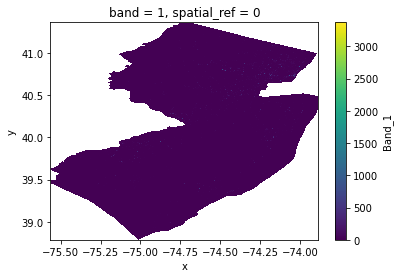

In [5]:
nj_day.plot()

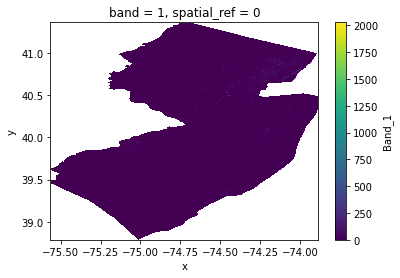

In [6]:
nj_night.plot()

In [7]:
nj_day.rio.resolution()

(0.0008333333299999925, -0.0008333333299999987)

In [8]:
print(nj_day.rio.crs)
print(nj_night.rio.crs)

EPSG:4326
EPSG:4326


## Convert population counts to integers

In [9]:
def floor_integer(xarray):
    """
    Cast float type xarray.DataArray with one variable to integer, taking the floor of the float values first.
    Produces the same result as directly casting to integer for values already close to their floor, but is
    more transparent and deliberate about value handling.
    """
    
    xarray_floor = xr.ufuncs.floor(xarray)
    xarray_floor = xarray_floor.fillna(0)
    xarray_floor = xarray_floor.astype('int')
    
    return xarray_floor

In [10]:
nj_night_int = floor_integer(nj_night)
nj_day_int = floor_integer(nj_day)

## Pad the extent with zeros to create a square

In [11]:
def make_divisible_square_extent(raster_xr, finalize_fxn, multiple=None):
    """
    pad raster with zeros to expand extent
    raster_xr: raster data in xarray
    multiple: None or integer value by which raster extent should be divisible
    """
    
    n_row = raster_xr.rio.height
    n_col = raster_xr.rio.width
    
    new_dim = max(n_row, n_col)
    
    # ensure the new dimensions are divisible by the desired aggregation scale
    if multiple:
        
        new_dim = math.ceil(new_dim/multiple) * multiple
    
    # extend the x and y coordinates at the appropriate resolutions
    y_resolution = raster_xr.rio.resolution()[1]
    x_resolution = raster_xr.rio.resolution()[0]
    
    start_x = raster_xr['x'][-1]
    start_y = raster_xr['y'][-1]
    
    # set the diagonal
    new_x = np.array([start_x + i*x_resolution for i in range(1, new_dim-n_col+1)])
    new_y = np.array([start_y + i*y_resolution for i in range(1, new_dim-n_row+1)])
    population = np.zeros((len(new_x), len(new_y))).astype(int)
    
    final_xr = finalize_fxn(new_x, new_y, population, raster_xr)
    
    return final_xr

def merge_datasets(new_x, new_y, population, original_array):
    
    extended_xr = xr.Dataset(
        data_vars=dict(population=(['x', 'y'], population)),
        coords=dict(
            x=(['x',], new_x),
            y=(['y',], new_y)
        )
    )
    
    final_xr = xr.combine_nested(
        [[original_array.to_dataset(name='population')], [extended_xr]], 
        concat_dim=['x', 'y']
    )
    print(final_xr)
    
    # fill NaN with 0 and recast type to int
    final_xr_array = final_xr.to_array()
    final_xr_array = final_xr_array.fillna(0)
    final_xr_array = final_xr_array.astype('int')
    
    # confirm no data loss (or gain) in concatenation
    try:
        total_a = np.nansum(original_array.values.flatten()) + np.nansum(extended_xr['population'].values.flatten())
        total_b = np.nansum(final_xr_array.values.flatten())
        print(f'Aggregate total = {total_a}; final total = {total_b}')
        assert total_a == total_b
    except AssertionError:
        print(f'Aggregate total {total_a} is not equal to final total {total_b}')
    
    return final_xr_array

In [12]:
agg_factor = 10
nj_night_square = make_divisible_square_extent(nj_night_int, merge_datasets, agg_factor)
nj_day_square = make_divisible_square_extent(nj_day_int, merge_datasets, agg_factor)

<xarray.Dataset>
Dimensions:      (y: 3090, band: 1, x: 3090)
Coordinates:
  * y            (y) float64 38.78 38.78 38.79 38.79 ... 41.36 41.36 41.36 41.36
  * band         (band) int64 1
  * x            (x) float64 -75.56 -75.56 -75.56 ... -72.99 -72.99 -72.99
    spatial_ref  int64 0
Data variables:
    population   (band, y, x) float64 dask.array<chunksize=(1, 90, 1000), meta=np.ndarray>
Aggregate total = 8882117; final total = 8882117
<xarray.Dataset>
Dimensions:      (y: 3090, band: 1, x: 3090)
Coordinates:
  * y            (y) float64 38.78 38.78 38.79 38.79 ... 41.36 41.36 41.36 41.36
  * band         (band) int64 1
  * x            (x) float64 -75.56 -75.56 -75.56 ... -72.99 -72.99 -72.99
    spatial_ref  int64 0
Data variables:
    population   (band, y, x) float64 dask.array<chunksize=(1, 90, 1000), meta=np.ndarray>
Aggregate total = 8943560; final total = 8943560


## Coarsen from 3 arcsecond to 30 arcsecond resolution (approx. 1km)

In [13]:
nj_night_coarse = nj_night_square.coarsen(boundary='pad', x=10, y=10).sum().compute()
nj_day_coarse = nj_day_square.coarsen(boundary='pad', x=10, y=10).sum().compute()

## Calculate average population from the coarsened data

In [14]:
nj_night_df = nj_night_coarse.to_dataframe(name='night_population').reset_index()
nj_day_df = nj_day_coarse.to_dataframe(name='day_population').reset_index()

In [15]:
nj_total = pd.merge(nj_night_df[['x', 'y', 'night_population']], nj_day_df[['x', 'y', 'day_population']], on=['x', 'y'])
nj_total['population'] = [(i[0] + i[1])/2 for i in zip(nj_total['day_population'], nj_total['night_population'])]

In [16]:
nj_avg_pop_only = nj_total.drop(['day_population', 'night_population'], axis=1).set_index(['x', 'y'])
nj_avg_pop_xr = nj_avg_pop_only.to_xarray().to_array()

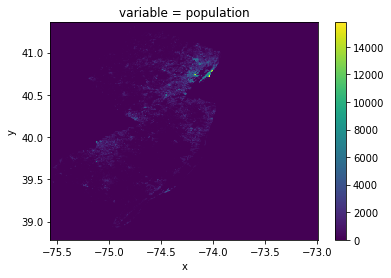

In [18]:
nj_avg_pop_xr.transpose().plot()

## Create a fishnet grid for NJ with average populations

In [21]:
from shapely.geometry import Polygon

In [22]:
# get the offset from the centroid to calculate bounding boxes
width = nj_avg_pop_xr.rio.resolution()[0]/2
height = nj_avg_pop_xr.rio.resolution()[1]/2

x_vals = []
y_vals = []
polygons = []
population = []
for x in nj_avg_pop_xr['x'].values:
    for y in nj_avg_pop_xr['y'].values:
        x_vals.append(x)
        y_vals.append(y)
        population.append(
            nj_avg_pop_xr.sel({'x': x, 'y': y}).values.item()
        )
        polygons.append(Polygon([(x-width,y-width), (x-width, y+height), (x+width, y+height), (x+width, y-height)]))

In [24]:
grid = gpd.GeoDataFrame(
    {
        'x': x_vals,
        'y': y_vals,
        'geometry': polygons,
        'population': population
    }
)

In [27]:
grid = grid.set_crs(nj_night.rio.crs) # they all have the same CRS

<AxesSubplot:>

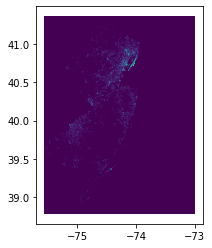

In [29]:
grid.plot(column='population')

## Trim padding

In [33]:
xmin, ymin, xmax, ymax = nj_night_int.rio.bounds()

In [34]:
trimmed_grid = grid[(grid['x'] >= xmin) & (grid['x'] <= xmax) & (grid['y'] >= ymin) & (grid['y'] <= ymax)]

<AxesSubplot:>

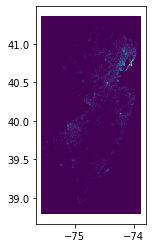

In [36]:
trimmed_grid.plot(column='population')

## Cut to shape of NJ

In [37]:
states = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tl_2018_us_state/tl_2018_us_state.shp')
nj = states[states['NAME'] == 'New Jersey']

<AxesSubplot:>

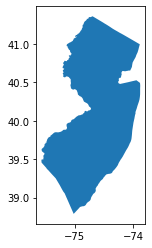

In [38]:
nj.plot()

In [40]:
nj = nj.to_crs(nj_night.rio.crs)

In [42]:
nj_final_fishnet = gpd.sjoin(trimmed_grid, nj, how='inner', op='intersects')

<AxesSubplot:>

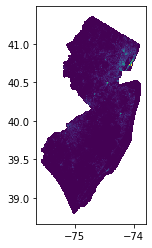

In [43]:
nj_final_fishnet.plot(column='population')

In [46]:
nj_final_fishnet = nj_final_fishnet[['x', 'y', 'geometry', 'population']]

In [47]:
nj_final_fishnet.head()

,x,y,geometry,population
80,-75.56,39.454167,"POLYGON ((-75.56417 39.45000, -75.56417 39.458...",0.0
81,-75.56,39.462500,"POLYGON ((-75.56417 39.45833, -75.56417 39.466...",0.0
82,-75.56,39.470833,"POLYGON ((-75.56417 39.46667, -75.56417 39.475...",0.0
83,-75.56,39.479167,"POLYGON ((-75.56417 39.47500, -75.56417 39.483...",0.0
84,-75.56,39.487500,"POLYGON ((-75.56417 39.48333, -75.56417 39.491...",0.0


In [48]:
nj_final_fishnet.to_file('NJ_1km_grid_2019.shp')